# Coursera Capstone - Part 3 - Visualize

## Start off by importing libraries

In [1]:
import requests # library to handle requests
import pandas as pd # library for data analysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation

#ALREADY INSTALLED FORGE USING ANACONDA PROMPT
!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 

# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#ALREADY INSTALLED FOLIUM USING ANACONDA PROMPT
!conda install -c conda-forge folium=0.5.0 #--yes
import folium # plotting library

print('Folium installed')
print('Libraries imported.')

Solving environment: | 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - anaconda/linux-64::conda-build==3.17.8=py36_0
  - anaconda/linux-64::grpcio==1.16.1=py36hf8bcb03_1
  - anaconda/linux-64::keras==2.1.5=py36_0
  - anaconda/linux-64::libarchive==3.3.3=h5d8350f_5
  - anaconda/linux-64::python-libarchive-c==2.8=py36_6
  - anaconda/linux-64::tensorboard==1.8.0=py36hf484d3e_0
  - anaconda/linux-64::tensorflow==1.8.0=h57681fa_0
  - anaconda/linux-64::tensorflow-base==1.8.0=py36h5f64886_0
  - defaults/linux-64::anaconda==5.3.1=py37_0
  - defaults/linux-64::astropy==3.0.4=py37h14c3975_0
  - defaults/linux-64::bkcharts==0.2=py37_0
  - defaults/linux-64::blaze==0.11.3=py37_0
  - defaults/linux-64::bokeh==0.13.0=py37_0
  - defaults/linux-64::bottleneck==1.2.1=py37h035aef0_1
  - defaults/linux-64::dask==0.19.1=py37_0
  - defaults/linux-64::datashape==0.5.4=py37_1
  - defaults/linux-64::mkl-service==1.1.2=py37h9

## Use Pandas and its features to read the target URL

In [2]:
#web scraping using pandas
#note: set header = 0 to use the first row as column headers

d = pd.read_html('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M', header=0)

#Interesting notes about the pandas list of tables that's created from reading the URL
#type(d) #prints 'list'
#print(len(d)) #prints '3' since there are 3 tables on this page. the one we want to use is index=0
#print(d[0]) #
#format of df['column_name']['row_#_in_column_name']

### Extract the table from the URL as a Pandas dataframe (note the shape and column names)

In [3]:
#set the target table to a 'dataframe'
df = d[0]

#check the shape of df
print(len(df)) #prints '289' is the # of rows (including the column name row)
print(df.shape) #prints '(289, 3)'
print(df.columns) #prints 'Index(['Postcode', 'Borough', 'Neighbourhood'], dtype='object')'

288
(288, 3)
Index(['Postcode', 'Borough', 'Neighbourhood'], dtype='object')


### Remove rows in the Borough column that are 'Not assigned' (and view the results)

In [4]:
#remove Postcodes that are "Not Assigned"
#df = df.drop(df[df.score < 50].index)
df_del_na = df.drop(df[df.Borough == 'Not assigned'].index)
df_del_na.head()

,Postcode,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M5A,Downtown Toronto,Regent Park
6,M6A,North York,Lawrence Heights


### Set Neighborhood from 'Not assigned' to "Queen's Park" (and view the results)

In [5]:
#set Neighborhood from 'Not assigned' to "Queen's Park"
df_del_na.loc[df_del_na['Neighbourhood'] == "Not assigned", 'Neighbourhood'] = "Queen's Park"
df_del_na.head(10)

,Postcode,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M5A,Downtown Toronto,Regent Park
6,M6A,North York,Lawrence Heights
7,M6A,North York,Lawrence Manor
8,M7A,Queen's Park,Queen's Park
10,M9A,Etobicoke,Islington Avenue
11,M1B,Scarborough,Rouge
12,M1B,Scarborough,Malvern


### Rename column name from 'Neighbourhood' to 'Neighborhood'

In [6]:
df_del_na.rename(columns={'Postcode': 'PostalCode', 'Neighbourhood': 'Neighborhood'}, inplace=True)
df_del_na.head()

,PostalCode,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M5A,Downtown Toronto,Regent Park
6,M6A,North York,Lawrence Heights


### Flatten the table (for the rows in the Neighborhood columns)

In [7]:
#flatten groupby results by setting Neighborhood to list per row
df_del_na_grouped_flat = df_del_na.groupby(['PostalCode', 'Borough'])['Neighborhood'].apply(lambda group_series: group_series.tolist()).reset_index()
print(df_del_na_grouped_flat.head(10), '\n', '\n')
print(df_del_na_grouped_flat.tail(10))

  PostalCode      Borough                                       Neighborhood
0        M1B  Scarborough                                   [Rouge, Malvern]
1        M1C  Scarborough           [Highland Creek, Rouge Hill, Port Union]
2        M1E  Scarborough                [Guildwood, Morningside, West Hill]
3        M1G  Scarborough                                           [Woburn]
4        M1H  Scarborough                                        [Cedarbrae]
5        M1J  Scarborough                              [Scarborough Village]
6        M1K  Scarborough      [East Birchmount Park, Ionview, Kennedy Park]
7        M1L  Scarborough                  [Clairlea, Golden Mile, Oakridge]
8        M1M  Scarborough  [Cliffcrest, Cliffside, Scarborough Village West]
9        M1N  Scarborough                      [Birch Cliff, Cliffside West] 
 

    PostalCode     Borough                                       Neighborhood
93         M9A   Etobicoke                                 [Islington A

### Read the csv into a pandas dataframe

In [8]:
geofile = pd.read_csv('https://cocl.us/Geospatial_data')

### Rename the Postal Code column to PostalCode

In [9]:
geofile.rename(columns = {'Postal Code': 'PostalCode'}, inplace=True)

### Merge the two dataframes

In [10]:
df_combined = pd.merge(df_del_na_grouped_flat, geofile, how='left', on='PostalCode')

### View the merged dataframe

In [11]:
df_combined.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"[Rouge, Malvern]",43.806686,-79.194353
1,M1C,Scarborough,"[Highland Creek, Rouge Hill, Port Union]",43.784535,-79.160497
2,M1E,Scarborough,"[Guildwood, Morningside, West Hill]",43.763573,-79.188711
3,M1G,Scarborough,[Woburn],43.770992,-79.216917
4,M1H,Scarborough,[Cedarbrae],43.773136,-79.239476


In [12]:
df_combined[df_combined.Latitude < 43.8]

,PostalCode,Borough,Neighborhood,Latitude,Longitude
1,M1C,Scarborough,"[Highland Creek, Rouge Hill, Port Union]",43.784535,-79.160497
2,M1E,Scarborough,"[Guildwood, Morningside, West Hill]",43.763573,-79.188711
3,M1G,Scarborough,[Woburn],43.770992,-79.216917
4,M1H,Scarborough,[Cedarbrae],43.773136,-79.239476
5,M1J,Scarborough,[Scarborough Village],43.744734,-79.239476
6,M1K,Scarborough,"[East Birchmount Park, Ionview, Kennedy Park]",43.727929,-79.262029
7,M1L,Scarborough,"[Clairlea, Golden Mile, Oakridge]",43.711112,-79.284577
8,M1M,Scarborough,"[Cliffcrest, Cliffside, Scarborough Village West]",43.716316,-79.239476
9,M1N,Scarborough,"[Birch Cliff, Cliffside West]",43.692657,-79.264848
10,M1P,Scarborough,"[Dorset Park, Scarborough Town Centre, Wexford...",43.757410,-79.273304


### Plot the Neighborhoods

In [13]:
#Use a starting latitude and longitude to help center the Toronto area map:
latitude = 43.72
longitude = -79.4
venues_map = folium.Map(location=[latitude, longitude], zoom_start=11.5) # generate map centred around the Conrad Hotel

# add the Italian restaurants as blue circle markers
for lat, lng, label in zip(df_combined.Latitude, df_combined.Longitude, df_combined.PostalCode):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(venues_map)

# display map
venues_map

In [14]:
CLIENT_ID = 'HBIWSY1J1OXYRJV3GRFGMHIKD25MSPBZJSDBWVVQBEWM1YGB' # your Foursquare ID
CLIENT_SECRET = 'UBNOMB4NFKZWJU21DBEDHRHPFZEFNSPMK0RT2YFOV4DDN4BL' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: HBIWSY1J1OXYRJV3GRFGMHIKD25MSPBZJSDBWVVQBEWM1YGB
CLIENT_SECRET:UBNOMB4NFKZWJU21DBEDHRHPFZEFNSPMK0RT2YFOV4DDN4BL


#### Define Foursquare ID and Secret (hidden for GIT post)

### Define Foursquare Credentials and Version

In [15]:
def getNearbyVenues(postalcodes, names, latitudes, longitudes, radius=500, LIMIT=100):
    
    venues_list=[]
    for postalcode, name, lat, lng in zip(postalcodes, names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            postalcode,
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['PostalCode',
                  'Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

### Use the function that explores nearby venues

#### Now write the code to run the above function on each neighborhood and create a new dataframe called *toronto_venues*.

In [16]:
# type your answer here

toronto_venues = getNearbyVenues(postalcodes=df_combined['PostalCode'],
                                 names=df_combined['Neighborhood'],
                                   latitudes=df_combined['Latitude'],
                                   longitudes=df_combined['Longitude']
                                  )



['Rouge', 'Malvern']
['Highland Creek', 'Rouge Hill', 'Port Union']
['Guildwood', 'Morningside', 'West Hill']
['Woburn']
['Cedarbrae']
['Scarborough Village']
['East Birchmount Park', 'Ionview', 'Kennedy Park']
['Clairlea', 'Golden Mile', 'Oakridge']
['Cliffcrest', 'Cliffside', 'Scarborough Village West']
['Birch Cliff', 'Cliffside West']
['Dorset Park', 'Scarborough Town Centre', 'Wexford Heights']
['Maryvale', 'Wexford']
['Agincourt']
['Clarks Corners', 'Sullivan', "Tam O'Shanter"]
['Agincourt North', "L'Amoreaux East", 'Milliken', 'Steeles East']
["L'Amoreaux West"]
['Upper Rouge']
['Hillcrest Village']
['Fairview', 'Henry Farm', 'Oriole']
['Bayview Village']
['Silver Hills', 'York Mills']
['Newtonbrook', 'Willowdale']
['Willowdale South']
['York Mills West']
['Willowdale West']
['Parkwoods']
['Don Mills North']
['Flemingdon Park', 'Don Mills South']
['Bathurst Manor', 'Downsview North', 'Wilson Heights']
['Northwood Park', 'York University']
['CFB Toronto', 'Downsview East']
['Down

In [17]:
toronto_venues.sample(10)

,PostalCode,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
1936,M6H,"[Dovercourt Village, Dufferin]",43.669005,-79.442259,Rush Hour,43.671183,-79.440313,Portuguese Restaurant
63,M1S,[Agincourt],43.794200,-79.262029,Mark's,43.791179,-79.259714,Clothing Store
396,M4K,"[The Danforth West, Riverdale]",43.679557,-79.352188,Pan on the Danforth,43.678263,-79.348648,Greek Restaurant
2105,M6S,"[Runnymede, Swansea]",43.651571,-79.484450,Classico,43.649194,-79.484699,Pizza Place
1451,M5L,"[Commerce Court, Victoria Hotel]",43.648198,-79.379817,Jump,43.648147,-79.378752,American Restaurant
467,M4M,[Studio District],43.659526,-79.340923,Cask,43.661790,-79.337452,Music Store
2137,M7A,[Queen's Park],43.662301,-79.389494,Buddies In Bad Times Theatre,43.663059,-79.383449,Nightclub
437,M4M,[Studio District],43.659526,-79.340923,Mercury Espresso Bar,43.660806,-79.341241,Coffee Shop
760,M5B,"[Ryerson, Garden District]",43.657162,-79.378937,The Queen and Beaver Public House,43.657472,-79.383524,Gastropub
1347,M5K,"[Design Exchange, Toronto Dominion Centre]",43.647177,-79.381576,deKEFIR,43.650433,-79.379393,Ice Cream Shop


In [18]:
#export combined dataframe to excel (optional)
toronto_venues.to_excel("toronto_venues.xlsx")

In [114]:
toronto_venues.shape

(2265, 8)

### Analyze the number of Venues per Postal Code

In [19]:
#sort counts descending (from largest to smallest)
toronto_venues.groupby(['PostalCode'])['Venue'].count().sort_values(ascending=False).head(20)

PostalCode
M5B    100
M5C    100
M5H    100
M5J    100
M5K    100
M5L    100
M5T    100
M5X    100
M5W     98
M4Y     86
M5G     85
M6J     64
M2J     63
M5E     58
M5A     50
M4X     43
M4K     41
M4M     41
M7A     41
M6S     39
Name: Venue, dtype: int64

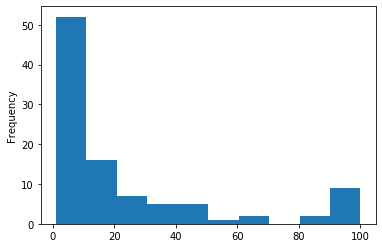

In [25]:
#plot the counts
toronto_venues.groupby(['PostalCode'])['Venue'].count().plot.hist()

### Plot the Venue counts

#### Create a boolean dataframe showing Postal Codes with Venue counts (>= 50 is True)

In [88]:
toronto_venues_50_df = pd.DataFrame((toronto_venues.groupby(['PostalCode'])['Venue'].count() >= 50))
toronto_venues_50_df #shows rows as boolean True/False

,Venue
PostalCode,
M1B,False
M1C,False
M1E,False
M1G,False
M1H,False
M1J,False
M1K,False
M1L,False
M1M,False


#### Rename Venue column to "Venue_bool50" to reflect boolean type

In [90]:
#set venue column to bool heading
toronto_venues_50_df.rename(columns = {'Venue': 'Venue_bool50'}, inplace=True)
toronto_venues_50_df                            

,Venue_bool50
PostalCode,
M1B,False
M1C,False
M1E,False
M1G,False
M1H,False
M1J,False
M1K,False
M1L,False
M1M,False


#### Create subset Postal Codes with Venue counts >= 50 (use later to filter toronto dataframe)

In [105]:
postalcodes_to_keep = toronto_venues_50_df[toronto_venues_50_df['Venue_bool50']==True].index
postalcodes_to_keep

Index(['M2J', 'M4Y', 'M5A', 'M5B', 'M5C', 'M5E', 'M5G', 'M5H', 'M5J', 'M5K',
       'M5L', 'M5T', 'M5W', 'M5X', 'M6J'],
      dtype='object', name='PostalCode')

##### NEXT STEPS: ADD COUNT ANALYSIS FROM DS0103EN-3-3-1
  1. maybe add .agg() function from PYCON (it creates a df)
  2. count recipes

#### Filter Toronto dataframe for Postal Codes that have Venue counts >=0

In [111]:
toronto_venues_50count = toronto_venues.loc[toronto_venues['PostalCode'].isin(postalcodes_to_keep)]
toronto_venues_50count.head(10)

,PostalCode,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
98,M2J,"[Fairview, Henry Farm, Oriole]",43.778517,-79.346556,The LEGO Store,43.778207,-79.343483,Toy / Game Store
99,M2J,"[Fairview, Henry Farm, Oriole]",43.778517,-79.346556,SilverCity Fairview Mall Cinemas,43.778681,-79.344085,Movie Theater
100,M2J,"[Fairview, Henry Farm, Oriole]",43.778517,-79.346556,CF Fairview Mall,43.777750,-79.344105,Shopping Mall
101,M2J,"[Fairview, Henry Farm, Oriole]",43.778517,-79.346556,Michel's Baguette,43.777082,-79.344557,Bakery
102,M2J,"[Fairview, Henry Farm, Oriole]",43.778517,-79.346556,Shoppers Drug Mart,43.778878,-79.344697,Pharmacy
103,M2J,"[Fairview, Henry Farm, Oriole]",43.778517,-79.346556,Hero Certified Burgers,43.777295,-79.344584,Burger Joint
104,M2J,"[Fairview, Henry Farm, Oriole]",43.778517,-79.346556,DAVIDsTEA,43.777545,-79.345263,Tea Room
105,M2J,"[Fairview, Henry Farm, Oriole]",43.778517,-79.346556,Apple Fairview,43.777915,-79.343561,Electronics Store
106,M2J,"[Fairview, Henry Farm, Oriole]",43.778517,-79.346556,Purdys Chocolatier,43.778099,-79.343853,Candy Store
107,M2J,"[Fairview, Henry Farm, Oriole]",43.778517,-79.346556,Moxie's Classic Grill,43.777779,-79.343185,American Restaurant


In [113]:
toronto_venues_50count.shape

(1304, 8)

In [ ]:
# set number of clusters
kclusters = 5

#manhattan_grouped_clustering = manhattan_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_combined)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 
#error: set an array element with a sequence.

#### Clusters pending